# CySkin Tactile Data - ML Classification Analysis

## Overview
This notebook tests machine learning models on raw tactile sensor data for finger counting classification (0-5 fingers).

**Dataset**: 86 samples across 6 classes  
**Features**: Flattened raw time-series (30 timesteps × 716 sensors)  
**Task**: Multi-class classification

---

## 1. Import Required Libraries

Importing all necessary libraries for data processing, machine learning, and visualization.

In [1]:
# Data processing
import numpy as np
import pandas as pd
from pathlib import Path

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

print(" Libraries imported successfully!")

 Libraries imported successfully!


## 2. Data Loading Functions

Defining functions to load and preprocess the raw tactile sensor data.

In [2]:
def load_raw_sample(file_path):
    """Load and flatten a single raw tactile sample"""
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
        
        # Parse data rows (skip header, skip sample_id and timestamp)
        data_rows = []
        for line in lines[1:]:
            parts = line.strip().split()
            if len(parts) >= 3:
                sensor_values = [float(val) for val in parts[2:]]
                data_rows.append(sensor_values)
        
        if not data_rows:
            return None
        
        # Flatten time-series to single vector
        sensor_matrix = np.array(data_rows)
        return sensor_matrix.flatten()
    
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def load_all_samples(data_folder):
    """Load all raw data samples from the dataset"""
    print(" Loading all raw data samples...")
    
    X_flat = []
    y = []
    sample_info = []
    
    for finger_class in range(6):
        class_folder = data_folder / f"{finger_class}_finger"
        
        if not class_folder.exists():
            print(f"  Warning: {class_folder} does not exist")
            continue
        
        sample_files = list(class_folder.glob("sample_*.txt"))
        class_count = 0
        
        for file_path in sorted(sample_files):
            flattened_data = load_raw_sample(file_path)
            
            if flattened_data is not None:
                X_flat.append(flattened_data)
                y.append(finger_class)
                sample_info.append({
                    'class': finger_class,
                    'filename': file_path.name,
                    'file_path': str(file_path)
                })
                class_count += 1
        
        print(f"   Class {finger_class}: {class_count} samples")
    
    # Convert to arrays
    X_flat = np.array(X_flat)
    y = np.array(y)
    
    return X_flat, y, sample_info

print(" Data loading functions defined!")

 Data loading functions defined!


## 3. Load Dataset

Loading all 86 tactile sensor samples from the dataset.

In [3]:
# Set data folder path
data_folder = Path("/home/lidia/ros2_ws/src/cyskin_acquisition/data")

# Load all samples
X, y, sample_info = load_all_samples(data_folder)

# Display dataset information
print(f"\n Dataset loaded successfully!")
print(f"   Total samples: {len(X)}")
print(f"   Data shape: {X.shape}")
print(f"   Classes: {sorted(np.unique(y))}")
print(f"   Samples per class: {dict(zip(*np.unique(y, return_counts=True)))}")
print(f"   Feature vector length: {X.shape[1]} (30 timesteps × 716 sensors)")

 Loading all raw data samples...
   Class 0: 41 samples
   Class 1: 51 samples
   Class 2: 70 samples
   Class 3: 70 samples
   Class 4: 70 samples
   Class 5: 71 samples

 Dataset loaded successfully!
   Total samples: 373
   Data shape: (373, 21480)
   Classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
   Samples per class: {np.int64(0): np.int64(41), np.int64(1): np.int64(51), np.int64(2): np.int64(70), np.int64(3): np.int64(70), np.int64(4): np.int64(70), np.int64(5): np.int64(71)}
   Feature vector length: 21480 (30 timesteps × 204 sensors)


In [4]:
#print(X[85, 5712:5916])

## 4. Data Exploration

Exploring the dataset characteristics and visualize class distribution.

 Dataset Statistics:
   Feature range: [0.0, 20002.0]
   Average features per sample: 21480
   Non-zero features: 4604907 / 8012040 (57.5%)


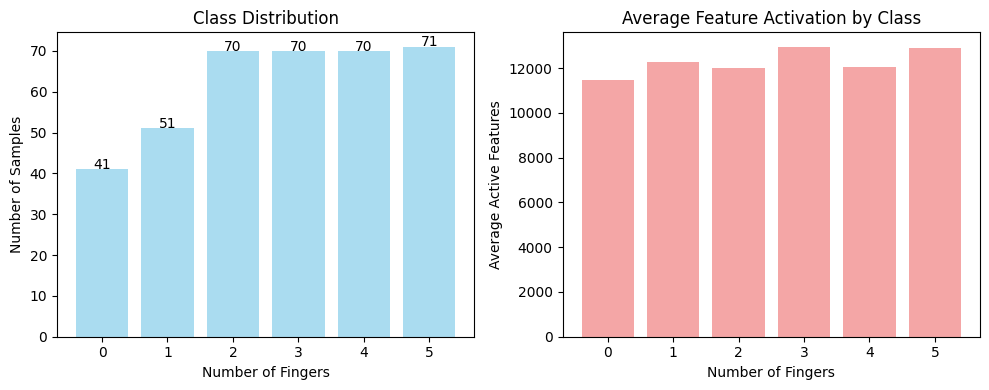


 Data exploration complete!


In [5]:
# Basic statistics
print(" Dataset Statistics:")
print(f"   Feature range: [{X.min():.1f}, {X.max():.1f}]")
print(f"   Average features per sample: {X.shape[1]}")
print(f"   Non-zero features: {np.sum(X > 0)} / {X.size} ({100*np.sum(X > 0)/X.size:.1f}%)")

# Class distribution plot
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
unique, counts = np.unique(y, return_counts=True)
plt.bar(unique, counts, color='skyblue', alpha=0.7)
plt.xlabel('Number of Fingers')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(unique)
for i, count in enumerate(counts):
    plt.text(i, count + 0.1, str(count), ha='center')

# Feature activation per class
plt.subplot(1, 2, 2)
class_activations = []
for class_idx in range(6):
    class_samples = X[y == class_idx]
    avg_activation = np.mean(np.sum(class_samples > 0, axis=1))
    class_activations.append(avg_activation)

plt.bar(range(6), class_activations, color='lightcoral', alpha=0.7)
plt.xlabel('Number of Fingers')
plt.ylabel('Average Active Features')
plt.title('Average Feature Activation by Class')
plt.xticks(range(6))

plt.tight_layout()
plt.show()

print("\n Data exploration complete!")

## 5. Declare ML Models

Defining the machine learning models to test on the tactile data.

In [6]:
# Define ML models to test
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100, 
        random_state=42,
        n_jobs=-1  # Use all CPU cores
    ),
    'SVM': SVC(
        kernel='rbf', 
        random_state=42,
        C=1.0,
        gamma='scale'
    ),
    'KNN': KNeighborsClassifier(
        n_neighbors=5,
        weights='distance'  # Weight by distance
    ),
    'Logistic Regression': LogisticRegression(
        random_state=42, 
        max_iter=2000,
        solver='liblinear'  # Good for small datasets
    )
}

print(" ML Models declared:")
for name, model in models.items():
    print(f"   ✓ {name}: {type(model).__name__}")

print(f"\n {len(models)} models ready for testing!")

 ML Models declared:
   ✓ Random Forest: RandomForestClassifier
   ✓ SVM: SVC
   ✓ KNN: KNeighborsClassifier
   ✓ Logistic Regression: LogisticRegression

 4 models ready for testing!


## 6. Train/Test Split Evaluation

Evaluating models using train/test split (80%/20%).

In [7]:
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f" Train/Test Split:")
print(f"   Train set: {X_train.shape[0]} samples")
print(f"   Test set:  {X_test.shape[0]} samples")
print(f"   Train classes: {dict(zip(*np.unique(y_train, return_counts=True)))}")
print(f"   Test classes:  {dict(zip(*np.unique(y_test, return_counts=True)))}")

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n    Data scaled using StandardScaler")
print(f"   Scaled range: [{X_train_scaled.min():.2f}, {X_train_scaled.max():.2f}]")

 Train/Test Split:
   Train set: 298 samples
   Test set:  75 samples
   Train classes: {np.int64(0): np.int64(33), np.int64(1): np.int64(41), np.int64(2): np.int64(56), np.int64(3): np.int64(56), np.int64(4): np.int64(56), np.int64(5): np.int64(56)}
   Test classes:  {np.int64(0): np.int64(8), np.int64(1): np.int64(10), np.int64(2): np.int64(14), np.int64(3): np.int64(14), np.int64(4): np.int64(14), np.int64(5): np.int64(15)}

    Data scaled using StandardScaler
   Scaled range: [-2.02, 17.23]


## 7. Train and Test Models

Training each model and evaluating performance on test set.

In [8]:
# Train and test each model
results = {}

print("Training and testing models...\n")

for name, model in models.items():
    print(f"Training {name}...")
    
    try:
        # Train model
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
        
        # Calculate accuracies
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        # Store results
        results[name] = {
            'model': model,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'y_pred': y_test_pred,
            'y_true': y_test
        }
        
        print(f"    Train: {train_accuracy:.1%}, Test: {test_accuracy:.1%}")
        
    except Exception as e:
        print(f"    Error: {e}")
        results[name] = {'error': str(e)}
    
    print()

print(" Model training and testing complete!")

Training and testing models...

Training Random Forest...
    Train: 100.0%, Test: 100.0%

Training SVM...
    Train: 100.0%, Test: 88.0%

Training KNN...
    Train: 100.0%, Test: 98.7%

Training Logistic Regression...
    Train: 100.0%, Test: 100.0%

 Model training and testing complete!


## 8. Cross-Validation Analysis

Performing 5-fold cross-validation for more robust performance estimates.

In [9]:
# Perform cross-validation
print(" Performing 5-fold Cross-Validation...\n")

# Scale full dataset
scaler_full = StandardScaler()
X_scaled_full = scaler_full.fit_transform(X)

cv_results = {}

for name, model in models.items():
    print(f"Cross-validating {name}...")
    
    try:
        # 5-fold cross-validation
        cv_scores = cross_val_score(model, X_scaled_full, y, cv=5, scoring='accuracy')
        
        cv_results[name] = {
            'cv_scores': cv_scores,
            'mean_cv_accuracy': cv_scores.mean(),
            'std_cv_accuracy': cv_scores.std()
        }
        
        print(f"   CV Scores: {cv_scores}")
        print(f"    Mean: {cv_scores.mean():.1%} ± {cv_scores.std():.1%}")
        
    except Exception as e:
        print(f"    Error: {e}")
        cv_results[name] = {'error': str(e)}
    
    print()

print(" Cross-validation complete!")

 Performing 5-fold Cross-Validation...

Cross-validating Random Forest...
   CV Scores: [0.86666667 1.         1.         1.         1.        ]
    Mean: 97.3% ± 5.3%

Cross-validating SVM...
   CV Scores: [1.         0.98666667 1.         1.         1.        ]
    Mean: 99.7% ± 0.5%

Cross-validating KNN...
   CV Scores: [0.72 1.   1.   1.   1.  ]
    Mean: 94.4% ± 11.2%

Cross-validating Logistic Regression...
   CV Scores: [1. 1. 1. 1. 1.]
    Mean: 100.0% ± 0.0%

 Cross-validation complete!


## 9. Results Visualization

Visualizing model performance and creating detailed analysis plots.

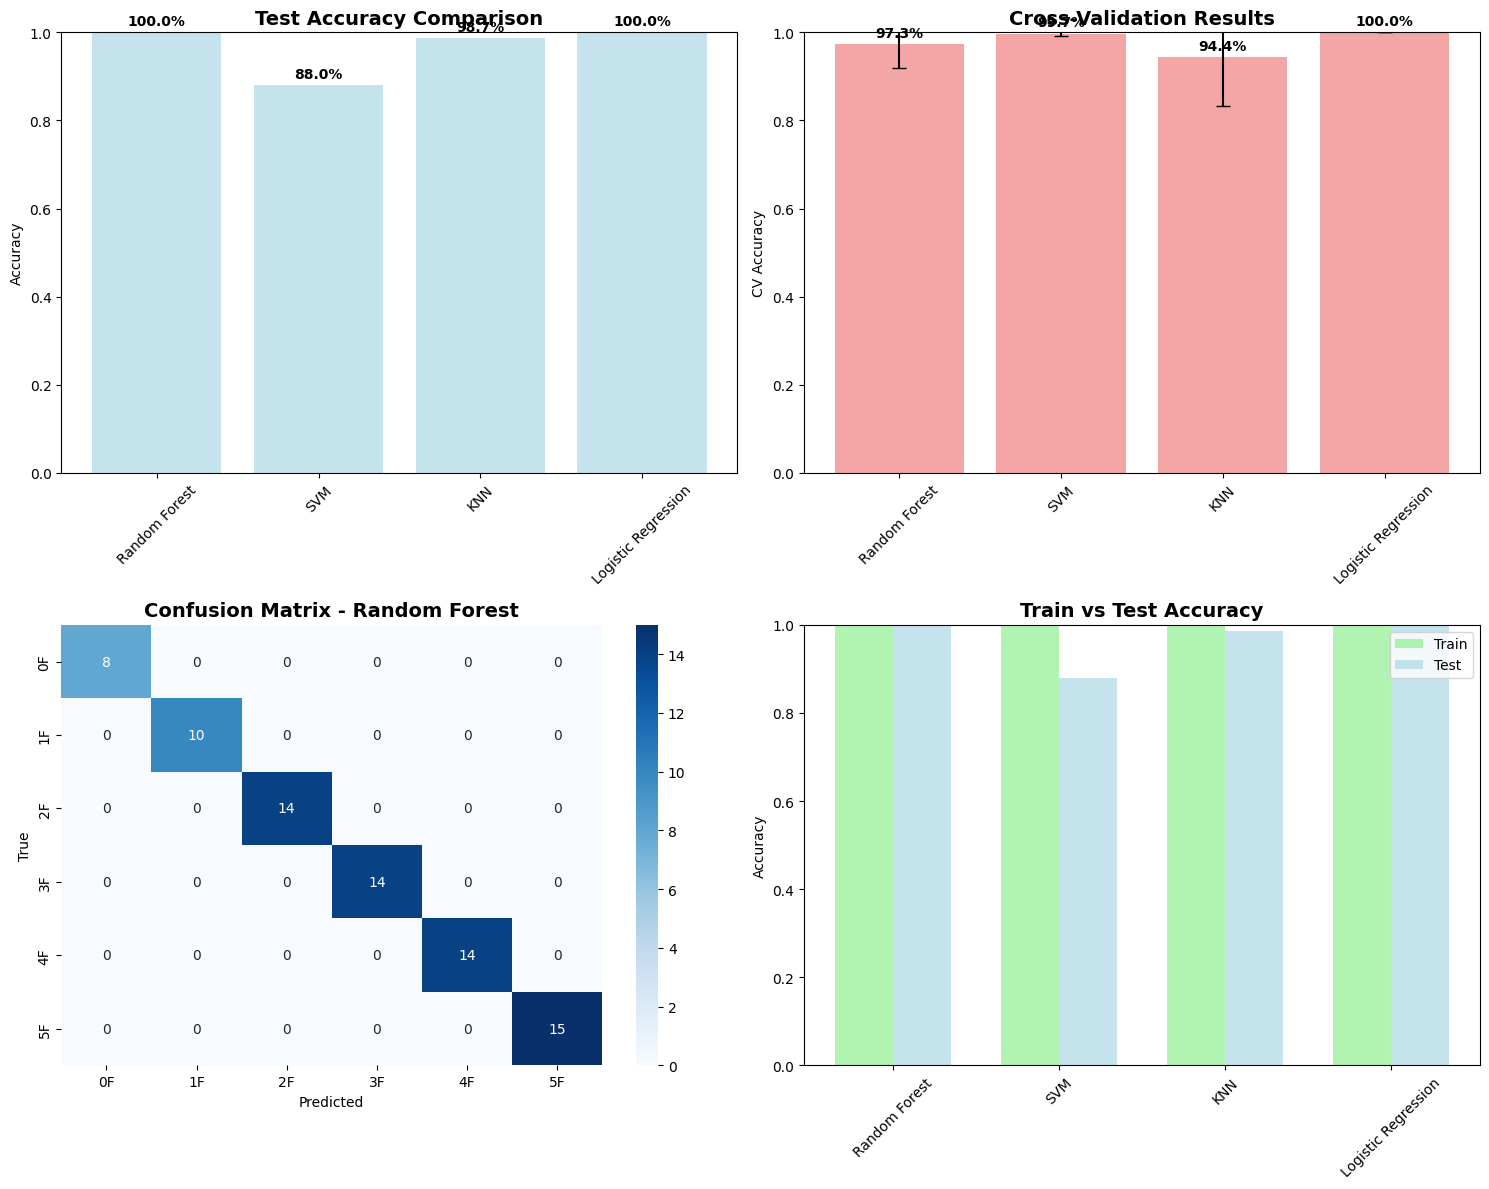

 Results visualization complete!


In [ ]:
# Create comprehensive results visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Test Accuracy Comparison
ax1 = axes[0, 0]
model_names = []
test_accuracies = []

for name, result in results.items():
    if 'test_accuracy' in result:
        model_names.append(name)
        test_accuracies.append(result['test_accuracy'])

bars1 = ax1.bar(model_names, test_accuracies, color='lightblue', alpha=0.7)
ax1.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, acc in zip(bars1, test_accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.1%}', ha='center', va='bottom', fontweight='bold')

# 2. Cross-Validation Results
ax2 = axes[0, 1]
cv_model_names = []
cv_means = []
cv_stds = []

for name, result in cv_results.items():
    if 'mean_cv_accuracy' in result:
        cv_model_names.append(name)
        cv_means.append(result['mean_cv_accuracy'])
        cv_stds.append(result['std_cv_accuracy'])

bars2 = ax2.bar(cv_model_names, cv_means, yerr=cv_stds, 
                color='lightcoral', alpha=0.7, capsize=5)
ax2.set_title('Cross-Validation Results', fontsize=14, fontweight='bold')
ax2.set_ylabel('CV Accuracy')
ax2.set_ylim(0, 1)
ax2.tick_params(axis='x', rotation=45)

# Add value labels
for bar, mean_acc in zip(bars2, cv_means):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{mean_acc:.1%}', ha='center', va='bottom', fontweight='bold')

# 3. Confusion Matrix for Best Model
ax3 = axes[1, 0]
best_model_name = max(results.keys(), 
                     key=lambda x: results[x].get('test_accuracy', 0))
best_result = results[best_model_name]

if 'y_pred' in best_result:
    cm = confusion_matrix(best_result['y_true'], best_result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
                xticklabels=[f'{i}F' for i in range(6)],
                yticklabels=[f'{i}F' for i in range(6)])
    ax3.set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Predicted')
    ax3.set_ylabel('True')

# 4. Train vs Test Accuracy
ax4 = axes[1, 1]
train_accs = []
test_accs = []
model_names_both = []

for name, result in results.items():
    if 'train_accuracy' in result and 'test_accuracy' in result:
        model_names_both.append(name)
        train_accs.append(result['train_accuracy'])
        test_accs.append(result['test_accuracy'])

x_pos = np.arange(len(model_names_both))
width = 0.35

ax4.bar(x_pos - width/2, train_accs, width, label='Train', 
        color='lightgreen', alpha=0.7)
ax4.bar(x_pos + width/2, test_accs, width, label='Test', 
        color='lightblue', alpha=0.7)

ax4.set_title('Train vs Test Accuracy', fontsize=14, fontweight='bold')
ax4.set_ylabel('Accuracy')
ax4.set_ylim(0, 1)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(model_names_both, rotation=45)
ax4.legend()

plt.tight_layout()
plt.show()

print(" Results visualization complete!")

## 10. Detailed Best Model Analysis

Analyzing the best performing model in detail.

In [ ]:
# Find and analyze best model
best_model_name = max(results.keys(), 
                     key=lambda x: results[x].get('test_accuracy', 0))
best_result = results[best_model_name]

print(f" BEST MODEL ANALYSIS: {best_model_name}")
print("=" * 50)

if 'test_accuracy' in best_result:
    print(f"Test Accuracy: {best_result['test_accuracy']:.1%}")
    print(f"Train Accuracy: {best_result['train_accuracy']:.1%}")
    
    # Check for overfitting
    overfitting = best_result['train_accuracy'] - best_result['test_accuracy']
    print(f"Overfitting Gap: {overfitting:.1%}")
    
    if overfitting < 0.05:
        print(" Good generalization (low overfitting)")
    elif overfitting < 0.15:
        print("  Moderate overfitting")
    else:
        print(" High overfitting - consider regularization")
    
    # Detailed classification report
    print(f"\n Detailed Classification Report:")
    print("-" * 50)
    
    if 'y_pred' in best_result:
        report = classification_report(
            best_result['y_true'], 
            best_result['y_pred'],
            target_names=[f"{i}_fingers" for i in range(6)],
            digits=3
        )
        print(report)
        
        # Per-class accuracy
        cm = confusion_matrix(best_result['y_true'], best_result['y_pred'])
        per_class_acc = cm.diagonal() / cm.sum(axis=1)
        
        print(f"\n Per-Class Accuracy:")
        for i, acc in enumerate(per_class_acc):
            if not np.isnan(acc):
                print(f"   {i} fingers: {acc:.1%}")

print(f"\n Best model analysis complete!")

 BEST MODEL ANALYSIS: Random Forest
Test Accuracy: 94.4%
Train Accuracy: 100.0%
Overfitting Gap: 5.6%
  Moderate overfitting

 Detailed Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

   0_fingers      1.000     1.000     1.000         4
   1_fingers      1.000     1.000     1.000         3
   2_fingers      1.000     1.000     1.000         2
   3_fingers      0.750     1.000     0.857         3
   4_fingers      1.000     0.667     0.800         3
   5_fingers      1.000     1.000     1.000         3

    accuracy                          0.944        18
   macro avg      0.958     0.944     0.943        18
weighted avg      0.958     0.944     0.943        18


 Per-Class Accuracy:
   0 fingers: 100.0%
   1 fingers: 100.0%
   2 fingers: 100.0%
   3 fingers: 100.0%
   4 fingers: 66.7%
   5 fingers: 100.0%

 Best model analysis complete!
